# 1. Imports

In [1]:
from utils.data_preparation import *
from utils.preprocessing import *
from models.model import *
from utils.optimizers import *
from utils.tools import *


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

import tqdm
import matplotlib.pyplot as plt

# 2. Data

In [2]:
path = '/mnt/d/AI-Workspace/sEMGClassification/BMIS_EMG_DATA/data/mat_data'
subject_number = 1
end_subject = 2
fs = 200
number_gestures=7
record_time = 5
train_repetition = [1, 2, 3, 4]
# train_repetition = [1]
test_repetition = [5, 6]
gesture = [1, 2, 3, 4, 5, 6, 7]
selected_gesture = [1, 2, 3, 4, 5, 6, 7]
num_gesture = len(gesture)


no_channel = 7

In [3]:
emg_prep = EMGDataPreparation(base_path=path, fs=200, rec_time=5)
train_data, train_labels, test_data, test_labels = emg_prep.load_multiple_subject(start_subject=1, end_subject=end_subject, num_gesture=num_gesture, train_repetition=train_repetition, test_repetition=test_repetition, selected_gesture=selected_gesture)

In [4]:
preprocess = EMGPreprocessing(fs=200, notch_freq=60.0, low_cut=10.0, high_cut=99.0, order=5)
train_data = preprocess.remove_mains(train_data)
test_data = preprocess.remove_mains(test_data)

train_data = preprocess.bandpass_filter(train_data)
test_data = preprocess.bandpass_filter(test_data)


window_train_data, window_train_labels = emg_prep.window_with_overlap(train_data, train_labels, window_time=200, overlap=60, no_channel=no_channel)
window_test_data, window_test_labels = emg_prep.window_with_overlap(test_data, test_labels, window_time=200, overlap=60, no_channel=no_channel)


window_train_data = np.expand_dims(window_train_data, axis=1)
window_test_data = np.expand_dims(window_test_data, axis=1)

window_train_data.shape, window_train_labels.shape, window_test_data.shape, window_test_labels.shape

((3498, 1, 7, 40), (3498,), (1748, 1, 7, 40), (1748,))

In [5]:
window_train_data, window_train_labels = shuffle_data(window_train_data, window_train_labels)
window_test_data, window_test_labels = shuffle_data(window_test_data, window_test_labels)


train_dataset = EMGDataset(window_train_data, window_train_labels)
test_dataset = EMGDataset(window_test_data, window_test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

In [6]:
def extract_support_n_query(data, labels, n_way, num_support, num_query):

    # N_WAYS = CLASSES
    # NUM_SUPPORT = NUMBER OF SUPPORT DATA PER CLASS
    # NUM_QUERY = NUMBER OF QUERY DATA PER CLASS

    support_query_data = []
    support_query_label = []
    K = np.random.choice(np.unique(labels), n_way, replace=False)
    for i in K:
        index = np.where(labels == i)
        data_per_class = data[index]
        labels_per_class = labels[index[0]]

        permuated_index = np.random.permutation(index[0])
        selected_index = permuated_index[:num_support+num_query]

        support_query_data.append(data[selected_index])
        support_query_label.append(labels[selected_index])
    
    support_query_data = np.array(support_query_data)
    support_query_label = np.array(support_query_label)

    return support_query_data,  support_query_label

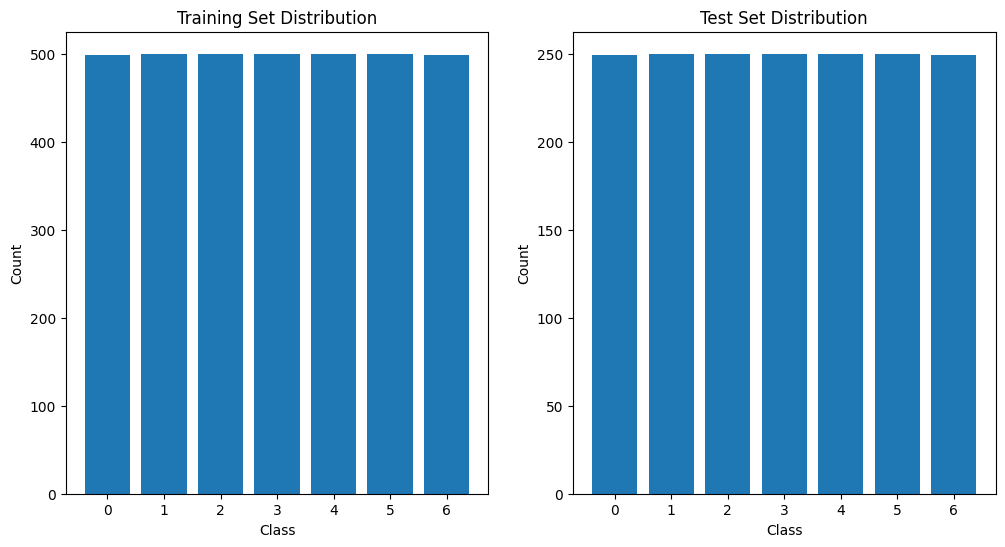

In [7]:
np.unique(window_train_labels, return_counts=True), np.unique(window_test_labels, return_counts=True)
counts_train = np.unique(window_train_labels, return_counts=True)
counts_test = np.unique(window_test_labels, return_counts=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(counts_train[0], counts_train[1])
ax[0].set_title('Training Set Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

ax[1].bar(counts_test[0], counts_test[1])
ax[1].set_title('Test Set Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.show()

# 3. EMGFAN Architecture

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EMGFANNew(1, number_gestures, similarparameter=False)
model.to(device)

EMGFANNew(
  (first): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FAN): FANLayer(
    (input_linear_p): Linear(in_features=576, out_features=64, bias=True)
    (input_linear_g): Linear(in_features=576, out_features=128, bias=True)
    (activation): GELU(approximate='none')
  )
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh3): ReLU()
  (last): Linear(in_features=256, out_features=7, bias=True)
)

In [9]:
save_emgfan_dir = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/PreTrain/7_Channels/emgfan_pretrain_15.pth'
model.load_state_dict(torch.load(save_emgfan_dir))

<All keys matched successfully>

# 4. Distance Metrics

In [10]:
def distance(query, support):

    n = query.size(0)
    m = support.size(0)
    d = query.size(1)
    assert d == support.size(1)

    query = query.unsqueeze(1).expand(n, m, d)
    support = support.unsqueeze(0).expand(n, m, d)

    dist = torch.pow(query - support, 2).sum(2)
    return dist

# 5. Calculate Loss and Accuracy

In [11]:
def set_forward_loss(model, data, n_way, n_support, n_query):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = data.cuda()
    n_way = n_way
    n_support = n_support
    n_query = n_query

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = model(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = distance(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

# 6. Training

In [12]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    
    #optimizer = optim.Adam(model.parameters(), lr = 0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far
    stop = False #status to know when to stop
    while epoch < max_epoch and not stop: # Breaks when max epoch is met
        running_loss = 0.0
        running_acc = 0.0
        # For 1 epoch run 2000 episodes
        # 1 Episode is 1 set of n_way classes with n_support and n_query samples each
        #for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
        for episode in tqdm.tqdm(range(epoch_size)):
            sample, _ = extract_support_n_query(train_x, train_y,n_way, n_support, n_query)
            sample = torch.from_numpy(sample).float()
            optimizer.zero_grad()
            model = model.cuda()
            loss, output = set_forward_loss(model, sample, n_way, n_support, n_query)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print(f'epoch :, {epoch}, loss :, {epoch_loss}, accuracy :, {epoch_acc*100:.2f}%')
        epoch += 1
        scheduler.step()

In [13]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 7
n_support = 5
n_query = 5

train_x = window_train_data
train_y = window_train_labels

max_epoch = 15
epoch_size = 2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

100%|██████████| 2000/2000 [00:08<00:00, 233.16it/s]


epoch :, 0, loss :, 3.0486901087500153, accuracy :, 76.25%


100%|██████████| 2000/2000 [00:09<00:00, 220.26it/s]


epoch :, 1, loss :, 0.397972563168034, accuracy :, 87.63%


100%|██████████| 2000/2000 [00:09<00:00, 219.17it/s]


epoch :, 2, loss :, 0.25949592532683163, accuracy :, 91.49%


100%|██████████| 2000/2000 [00:10<00:00, 194.96it/s]


epoch :, 3, loss :, 0.20102575309784151, accuracy :, 93.30%


100%|██████████| 2000/2000 [00:09<00:00, 202.47it/s]


epoch :, 4, loss :, 0.16580599951627664, accuracy :, 94.33%


100%|██████████| 2000/2000 [00:09<00:00, 214.77it/s]


epoch :, 5, loss :, 0.15992479530419224, accuracy :, 94.50%


100%|██████████| 2000/2000 [00:09<00:00, 215.53it/s]


epoch :, 6, loss :, 0.14825167169538325, accuracy :, 94.81%


100%|██████████| 2000/2000 [00:09<00:00, 217.83it/s]


epoch :, 7, loss :, 0.1481536323800683, accuracy :, 94.90%


100%|██████████| 2000/2000 [00:09<00:00, 216.24it/s]


epoch :, 8, loss :, 0.14315447927673813, accuracy :, 95.03%


100%|██████████| 2000/2000 [00:09<00:00, 213.19it/s]


epoch :, 9, loss :, 0.14050494785548653, accuracy :, 95.12%


100%|██████████| 2000/2000 [00:10<00:00, 199.57it/s]


epoch :, 10, loss :, 0.14132831729180179, accuracy :, 95.17%


100%|██████████| 2000/2000 [00:09<00:00, 201.95it/s]


epoch :, 11, loss :, 0.14215861490136011, accuracy :, 95.10%


100%|██████████| 2000/2000 [00:09<00:00, 207.43it/s]


epoch :, 12, loss :, 0.13912393453903496, accuracy :, 95.25%


100%|██████████| 2000/2000 [00:09<00:00, 222.02it/s]


epoch :, 13, loss :, 0.1417845741373021, accuracy :, 95.11%


100%|██████████| 2000/2000 [00:09<00:00, 213.09it/s]

epoch :, 14, loss :, 0.1435370176397264, accuracy :, 94.94%


In [14]:
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/MetaLearn/emgfan_7_c.pth'
torch.save(model.state_dict(), save_dir_meta)

# 7. Test

In [15]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):

    running_loss = 0.0
    running_acc = 0.0

    for episode in tqdm.tqdm(range(test_episode)):
        sample, _ = extract_support_n_query(test_x, test_y, n_way, n_support, n_query)
        sample = torch.from_numpy(sample).float()
        model = model.cuda()
        loss, output = set_forward_loss(model, sample, n_way, n_support, n_query)
        running_loss += output['loss']
        running_acc += output['acc']
    
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode

    print(f'Average Loss :, avg_loss, Average Accuracy :, {avg_acc*100:.2f}%')

In [18]:
n_way = 7
n_support = 5
n_query = 5

test_x = window_test_data
test_y = window_test_labels

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

100%|██████████| 1000/1000 [00:01<00:00, 504.47it/s]

Average Loss :, avg_loss, Average Accuracy :, 80.23%
